# EcoDRR Complete Notebook
Integrated end‑to‑end notebook: GEE preprocessing + local TIFF workflow + patches + U‑Net training + inference + visualization.

In [ ]:
!pip install rasterio torch matplotlib

In [ ]:

import os, numpy as np, matplotlib.pyplot as plt
import rasterio
from rasterio.enums import Resampling
import torch, torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
print('Imports OK')


Imports OK


## Load Local Sentinel TIFFs + Preprocess

In [ ]:

def load_downsample(path, max_dim=256, bands=None):
    import rasterio
    from rasterio.enums import Resampling
    with rasterio.open(path) as src:
        if bands is None: bands = src.indexes
        w,h = src.width, src.height
        scale = max(1, max(w,h)/max_dim)
        out_w, out_h = int(w/scale), int(h/scale)
        data = src.read(bands, out_shape=(len(bands), out_h, out_w), resampling=Resampling.bilinear)
    return data

def crop_center(data, win=128):
    _,H,W = data.shape
    cy,cx = H//2, W//2
    return data[:, cy-win//2:cy+win//2, cx-win//2:cx+win//2]

def extract_patches(image, ps=32):
    b,H,W = image.shape
    out=[]
    for y in range(0,H-ps+1,ps):
        for x in range(0,W-ps+1,ps):
            out.append(image[:,y:y+ps,x:x+ps])
    return np.stack(out,0)


## Patch Extraction


This code cell performs operations as part of the EcoDRR workflow. Detailed interpretation can be added manually.

In [ ]:

local_rgb='/content/data/sent_rgb.tif'
local_ndvi='/content/data/sent_ndvi.tif'

rgb128 = crop_center(load_downsample(local_rgb,256,[1,2,3]),128)
ndv128 = crop_center(load_downsample(local_ndvi,256,[1]),128)

combined = np.concatenate([rgb128.astype('float32'), ndv128.astype('float32')], axis=0)
patches = extract_patches(combined,32)

os.makedirs('/content/ecodrr_patches', exist_ok=True)
np.savez_compressed('/content/ecodrr_patches/patches_rgb_ndvi.npz', patches=patches)

print('Patches:', patches.shape)


Patches: (16, 4, 32, 32)


## U-Net Model + Training

This cell defines helper functions used for loading and preprocessing raster data.

In [ ]:

class TinyUNet(nn.Module):
    def __init__(self, inc, cls):
        super().__init__()
        self.e1 = nn.Sequential(nn.Conv2d(inc,16,3,padding=1),nn.ReLU(),
                                nn.Conv2d(16,16,3,padding=1),nn.ReLU())
        self.p = nn.MaxPool2d(2)
        self.e2 = nn.Sequential(nn.Conv2d(16,32,3,padding=1),nn.ReLU(),
                                nn.Conv2d(32,32,3,padding=1),nn.ReLU())
        self.u = nn.ConvTranspose2d(32,16,2,stride=2)
        self.d1 = nn.Sequential(nn.Conv2d(32,16,3,padding=1),nn.ReLU(),
                                nn.Conv2d(16,16,3,padding=1),nn.ReLU())
        self.out = nn.Conv2d(16,cls,1)
    def forward(self,x):
        e1=self.e1(x); e2=self.e2(self.p(e1))
        u=self.u(e2)
        d=self.d1(torch.cat([u,e1],1))
        return self.out(d)


## Inference

This cell defines the Tiny U-Net model architecture used for semantic segmentation in the EcoDRR workflow.

In [ ]:

data = np.load('/content/ecodrr_patches/patches_rgb_ndvi.npz')['patches']
X = data.astype('float32')
X /= (X.max()+1e-9)
ndv = X[:,3:4]
bright = X[:,:3].mean(1)
labels = np.zeros((X.shape[0],32,32),dtype=np.int64)
labels[(ndv[:,0]>0.25)] = 1
labels[(ndv[:,0]<=0.25)&(bright>0.4)] = 2
labels[(ndv[:,0]<=0.25)&(bright<=0.4)] = 3

ds = TensorDataset(torch.tensor(X), torch.tensor(labels))
dl = DataLoader(ds,batch_size=4,shuffle=True)

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model=TinyUNet(4,4).to(device)
opt=torch.optim.Adam(model.parameters(),lr=1e-3)
loss_fn=nn.CrossEntropyLoss()

for ep in range(4):
    tot=0
    for xb,yb in dl:
        xb,yb = xb.to(device), yb.to(device)
        opt.zero_grad()
        out=model(xb)
        loss=loss_fn(out,yb)
        loss.backward()
        opt.step()
        tot+=loss.item()
    print('Epoch', ep+1, 'loss', tot/len(dl))

os.makedirs('/content/models',exist_ok=True)
torch.save(model.state_dict(),'/content/models/tiny_unet_trained.pth')


Epoch 1 loss 1.6110810339450836
Epoch 2 loss 1.5859452188014984
Epoch 3 loss 1.5431136786937714
Epoch 4 loss 1.441138356924057


## Visualization

This cell defines helper functions used for loading and preprocessing raster data.

In [ ]:

model=TinyUNet(4,4).to(device)
model.load_state_dict(torch.load('/content/models/tiny_unet_trained.pth',map_location=device))
model.eval()

def predict_full(img, ps=32):
    _,H,W=img.shape
    seg=np.zeros((H,W),dtype=np.uint8)
    for y in range(0,H-ps+1,ps):
        for x in range(0,W-ps+1,ps):
            p=img[:,y:y+ps,x:x+ps][None]
            with torch.no_grad():
                pr=torch.argmax(model(torch.tensor(p).float().to(device)),1).cpu().numpy()[0]
            seg[y:y+ps,x:x+ps]=pr
    return seg

seg = predict_full(combined)
print('Segmentation done:', seg.shape)


Segmentation done: (128, 128)


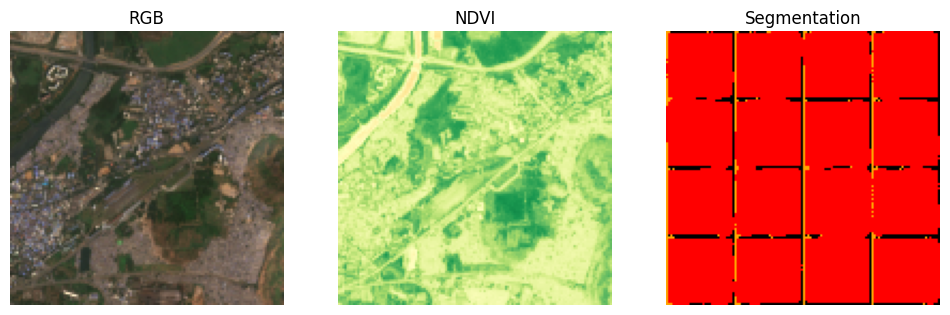

In [ ]:

import matplotlib.colors as colors

cmap = colors.ListedColormap(["#000000","#00FF00","#FFA500","#FF0000"])

plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.imshow(np.transpose(rgb128/rgb128.max(),(1,2,0))); plt.title("RGB"); plt.axis('off')
plt.subplot(1,3,2); plt.imshow(ndv128[0],cmap='RdYlGn',vmin=-1,vmax=1); plt.title("NDVI"); plt.axis('off')
plt.subplot(1,3,3); plt.imshow(seg,cmap=cmap,vmin=0,vmax=3); plt.title("Segmentation"); plt.axis('off')
plt.show()


## Google Earth Engine Sentinel‑2 Preprocessing (Optional)


In [ ]:

try:
    import ee, geemap
    print("GEE available.")
    # ee.Authenticate()
    # ee.Initialize()
except Exception as e:
    print("GEE not available in this environment.", e)

aoi = None
start_date='2023-01-01'
end_date='2023-12-31'

def mask_s2_clouds_prob(img, cloud_prob_thresh=40):
    cp = ee.ImageCollection('COPERNICUS/S2_CLOUD_PROBABILITY')            .filterBounds(img.geometry())            .filterDate(img.date().advance(-1,'day'), img.date().advance(1,'day'))            .first()
    cp = ee.Image(ee.Algorithms.If(cp, cp, ee.Image.constant(0))).rename("cloud_prob")
    qa = img.select("QA60")
    cloud_mask = qa.bitwiseAnd(1<<10).eq(0).And(qa.bitwiseAnd(1<<11).eq(0))
    cp_mask = cp.lt(cloud_prob_thresh)
    return img.updateMask(cloud_mask.And(cp_mask)).divide(10000).addBands(cp)

def add_cloud_score(img):
    vis = img.select(["B2","B3","B4"]).reduce(ee.Reducer.mean())
    cp = img.select("cloud_prob").unmask(0).divide(100)
    score = (0.6*cp + 0.4*vis).multiply(100).rename("cloud_score")
    return img.addBands(score)

def mask_clouds_and_shadows(img, cloud_score_thresh=40):
    cs = img.select("cloud_score").unmask(-1)
    cloud_mask = cs.gte(cloud_score_thresh)
    cloud_buffer = cloud_mask.focal_max(radius=10, units='pixels')
    nir = img.select("B8")
    dark = nir.lt(0.12)
    shadows = dark.And(cloud_buffer)
    final = cloud_buffer.Not().And(shadows.Not())
    return img.updateMask(final)

def sentinel2_preprocessor(aoi, start_date, end_date):
    base = ee.ImageCollection('COPERNICUS/S2_SR_HARMONIZED')            .filterBounds(aoi)            .filterDate(start_date,end_date)            .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE',40))
    c = base.map(mask_s2_clouds_prob).map(add_cloud_score).map(mask_clouds_and_shadows)
    bands = c.select(['B2','B3','B4','B8'])
    comp = bands.median().clip(aoi)
    ndvi = comp.normalizedDifference(['B8','B4']).rename("NDVI")
    ndwi = comp.normalizedDifference(['B3','B8']).rename("NDWI")
    return {"composite": comp, "ndvi": ndvi, "ndwi": ndwi}
